In [33]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [34]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [35]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [40]:
import random
import hashlib
%matplotlib inline

In [41]:
def disp_samples(data_folders, sample_size):
  for folder in data_folders:
    print(folder)
    image_files = os.listdir(folder)
    image_sample = random.sample(image_files, sample_size)
    for image in image_sample:
      image_file = os.path.join(folder, image)
      i = Image(filename=image_file)
      display(i)

In [42]:
disp_samples(train_folders, 1)

./notMNIST_large/A


./notMNIST_large/B


./notMNIST_large/C


./notMNIST_large/D


./notMNIST_large/E


./notMNIST_large/F


./notMNIST_large/G


./notMNIST_large/H


./notMNIST_large/I


./notMNIST_large/J


In [43]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

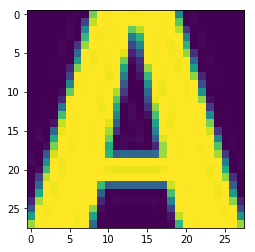

In [45]:
A_list = pickle.load(open("notMNIST_large/A.pickle", "rb"))

%matplotlib inline
plt.imshow(random.choice(A_list))

In [46]:
def disp_number_images(data_folders):
  for folder in data_folders:
    pickle_filename = ''.join(folder) + '.pickle'
    try:
      with open(pickle_filename, 'rb') as f:
        dataset = pickle.load(f)
    except Exception as e:
      print('Unable to read data from', pickle_filename, ':', e)
      return
    print('Number of images in ', folder, ' : ', len(dataset))
    
disp_number_images(train_folders)
disp_number_images(test_folders)

Number of images in  ./notMNIST_large/A  :  52909
Number of images in  ./notMNIST_large/B  :  52911
Number of images in  ./notMNIST_large/C  :  52912
Number of images in  ./notMNIST_large/D  :  52911
Number of images in  ./notMNIST_large/E  :  52912
Number of images in  ./notMNIST_large/F  :  52912
Number of images in  ./notMNIST_large/G  :  52912
Number of images in  ./notMNIST_large/H  :  52912
Number of images in  ./notMNIST_large/I  :  52912
Number of images in  ./notMNIST_large/J  :  52911
Number of images in  ./notMNIST_small/A  :  1872
Number of images in  ./notMNIST_small/B  :  1873
Number of images in  ./notMNIST_small/C  :  1873
Number of images in  ./notMNIST_small/D  :  1873
Number of images in  ./notMNIST_small/E  :  1873
Number of images in  ./notMNIST_small/F  :  1872
Number of images in  ./notMNIST_small/G  :  1872
Number of images in  ./notMNIST_small/H  :  1872
Number of images in  ./notMNIST_small/I  :  1872
Number of images in  ./notMNIST_small/J  :  1872


In [48]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [50]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [52]:
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def disp_sample_dataset(dataset, labels):
  items = random.sample(range(len(labels)), 8)
  for i, item in enumerate(items):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(pretty_labels[labels[item]])
    plt.imshow(dataset[item])

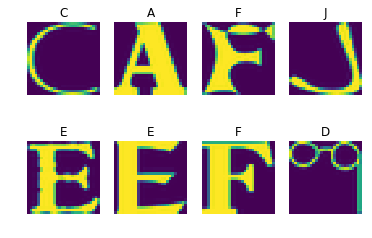

In [53]:
disp_sample_dataset(train_dataset, train_labels)

In [54]:

pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [55]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 690800512


In [56]:
all_data = pickle.load(open('notMNIST.pickle', 'rb'))

def count_duplicates(dataset1, dataset2):
    hashes = [hashlib.sha1(x).hexdigest() for x in dataset1]
    dup_indices = []
    for i in range(0, len(dataset2)):
        if hashlib.sha1(dataset2[i]).hexdigest() in hashes:
            dup_indices.append(i)
    return len(dup_indices)


print(count_duplicates(all_data['test_dataset'], all_data['valid_dataset']))
print(count_duplicates(all_data['valid_dataset'], all_data['train_dataset']))
print(count_duplicates(all_data['test_dataset'], all_data['train_dataset']))

168
3465
3494


In [57]:
train_dataset = all_data['train_dataset']
train_labels = all_data['train_labels']
test_dataset = all_data['test_dataset']
test_labels = all_data['test_labels']

In [58]:
def get_score(train_dataset, train_labels, test_dataset, test_labels):
    model = LogisticRegression()
    train_flatten_dataset = np.array([x.flatten() for x in train_dataset])
    test_flatten_dataset = np.array([x.flatten() for x in test_dataset])
    model.fit(train_flatten_dataset, train_labels)

    return model.score([x.flatten() for x in test_dataset], test_labels)

print("100 trainsamples score: " + str(get_score(train_dataset[:100], train_labels[:100], test_dataset, test_labels)))
print("1000 trainsamples score: " + str(get_score(train_dataset[:1000], train_labels[:1000], test_dataset, test_labels)))
print("5000 trainsamples score: " + str(get_score(train_dataset[:5000], train_labels[:5000], test_dataset, test_labels)))
print("10000 trainsamples score: " + str(get_score(train_dataset[:10000], train_labels[:10000], test_dataset, test_labels)))
print("all trainsamples score: " + str(get_score(train_dataset, train_labels, test_dataset, test_labels)))

100 trainsamples score: 0.7645
1000 trainsamples score: 0.8341
5000 trainsamples score: 0.8499
10000 trainsamples score: 0.86
all trainsamples score: 0.8901
